In [129]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 🔹 Load Dataset
df = pd.read_csv("/kaggle/input/college-basketball-dataset/cbb.csv")

df = df[df["POSTSEASON"].notnull()]  # Only teams that made the tournament

# ✅ Define ordered POSTSEASON categories (including R68)
postseason_order = ['R68', 'R64', 'R32', 'S16', 'E8', 'F4', '2ND', 'Champ']
label_map = {label: idx for idx, label in enumerate(postseason_order)}
df = df[df["POSTSEASON"].isin(label_map)]
df["POSTSEASON_ENC"] = df["POSTSEASON"].map(label_map)
num_classes = len(postseason_order)

# ➕ Feature Engineering: Derived Metrics
df["NET_EFFICIENCY"] = df["ADJOE"] - df["ADJDE"]
df["EFF_TEMPO"] = df["NET_EFFICIENCY"] * df["ADJ_T"]
df["TOR_RATIO"] = df["TOR"] / (df["TORD"] + 1e-5)
df["REB_RATIO"] = df["ORB"] / (df["DRB"] + 1e-5)
df["3P_vs_2P"] = df["3P_O"] / (df["2P_O"] + 1e-5)

# ✖️ Interaction Terms
df["EFG_x_TOR"] = df["EFG_O"] * df["TOR"]
df["ORB_x_FTR"] = df["ORB"] * df["FTR"]
df["PPS"] = ((3 * df["3P_O"] + 2 * df["2P_O"]) / 8)
df["RPPS"] = df["PPS"] - ((3 * df["3P_D"] + 2 * df["2P_D"]) / 6)

df["RPPP"] = (df["RPPS"] * (df["ADJ_T"] / 40))


df["UPSET_FACTOR"] = df["WAB"] / df["SEED"]

# 🔹 Filter 2025 data
df_2025 = pd.read_csv("/kaggle/input/college-basketball-dataset/cbb25.csv")
df_2025["PPS"] = ((3 * df_2025["3P_O"] + 2 * df_2025["2P_O"]) / 8)
df_2025["RPPS"] = df_2025["PPS"] - ((3 * df_2025["3P_D"] + 2 * df_2025["2P_D"]) / 6)
df_2025["RPPP"] = (df_2025["RPPS"] * (df_2025["ADJ_T"] / 40))
df_2025["UPSET_FACTOR"] = df_2025["WAB"] / df_2025["SEED"]
df_2025["REB_RATIO"] = df_2025["ORB"] / (df_2025["DRB"] + 1e-5)
df_2025["YEAR"] = 2025

# 🧠 Prepare 2025 features (must match original features used in training)
X_2025 = df_2025[features].values
scaler = StandardScaler()
X_2025_scaled = scaler.fit_transform(X_2025)


# ✅ Select features
features = [
    "RPPP", "REB_RATIO", "UPSET_FACTOR", "YEAR"
]

X = df[features].values
y = df["POSTSEASON_ENC"].values

# ⚖️ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔀 Train/Test Split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 🔄 Transform to ordinal format: shape = (num_samples, num_classes - 1)
def make_ordinal_labels(y, num_classes):
    return np.array([[1 if label >= j else 0 for j in range(num_classes - 1)] for label in y])

y_train = make_ordinal_labels(y_train_raw, num_classes)
y_test = make_ordinal_labels(y_test_raw, num_classes)

# 🧠 Ordinal Model
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.GaussianNoise(0.1),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.BatchNormalization(),

    layers.Dense(num_classes - 1, activation='sigmoid')  # K - 1 thresholds
])

import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_raw),
    y=y_train_raw
)

# Build a weight mapping
class_weight_dict = dict(enumerate(class_weights))

# Use Series for better indexing
sample_weights_series = pd.Series(y_train_raw).map(class_weight_dict)



Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 99: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 132: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 147: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 155: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Test Accuracy (per-threshold binary): 0.980

Classification Report:
              precision    recall  f1-score   support

         R64       0.50      0.22      0.31         9
         R32       0.59      0.70      0.64        71
         S16       0.21      0.23      0.22        35
          E8       0.30      0.17      0.21        18
          F4       0.00      0.00      0.00         9
         2ND       0.00      0.00      0.00         4
       Champ       1.00      0.50      0.67         2

    accuracy                           0.43       148
   macro avg 

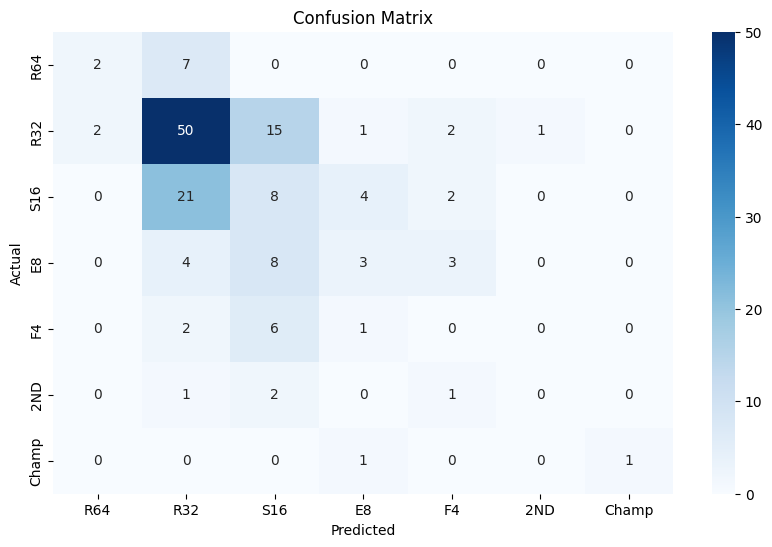

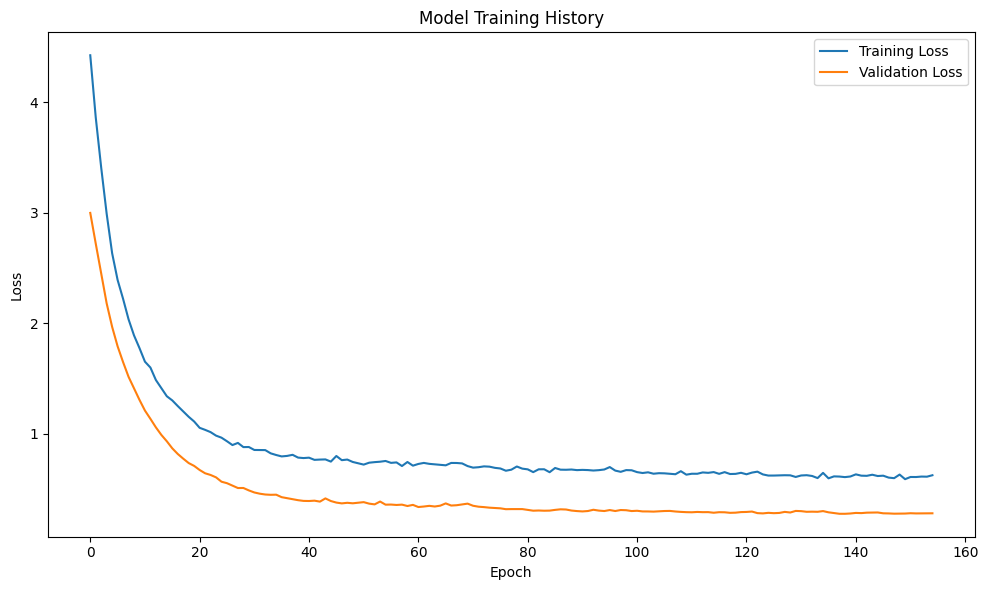


Mean Absolute Error (Ordinal Distance): 0.79


In [130]:
# 🚀 Training

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# 🛑 Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=16, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=8, 
    verbose=1, 
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    callbacks=[early_stopping, reduce_lr],
    epochs=1000,
    batch_size=8,
    validation_split=0.2,
    verbose=0,
    class_weight=sample_weights_series
)

# 🔍 Prediction & Evaluation
def from_ordinal_output(output):
    return np.sum(output > 0.5, axis=1)

y_pred_proba = model.predict(X_test)
y_pred_classes = from_ordinal_output(y_pred_proba)
y_test_labels = from_ordinal_output(y_test)

# 📈 Evaluation
print(f"\nTest Accuracy (per-threshold binary): {model.evaluate(X_test, y_test, verbose=0)[1]:.3f}")

present_labels = unique_labels(y_test_labels, y_pred_classes)
present_class_names = [postseason_order[i] for i in present_labels]

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_classes, target_names=present_class_names))

# Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_classes),
    annot=True,
    fmt='d',
    xticklabels=present_class_names,
    yticklabels=present_class_names,
    cmap='Blues'
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Mean Absolute Error (Ordinal Distance)
mae = np.mean(np.abs(y_pred_classes - y_test_labels))
print(f"\nMean Absolute Error (Ordinal Distance): {mae:.2f}")

In [131]:
# 🔍 Predict using trained model
y_2025_pred_proba = model.predict(X_2025_scaled)
y_2025_pred_classes = from_ordinal_output(y_2025_pred_proba)

# 🔄 Map predictions to postseason labels
df_2025["Predicted_POSTSEASON"] = [postseason_order[i] for i in y_2025_pred_classes]

# 📝 Save predictions to CSV
df_2025[["Team", "Predicted_POSTSEASON"]].to_csv("2025_predictions.csv", index=False)
print("✅ Predictions saved to 2025_predictions.csv")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[0.99947673 0.9997226  0.9975135  ... 0.9259068  0.44568336 0.28737932]
 [0.9981819  0.99929893 0.99534124 ... 0.9281923  0.54752564 0.40237075]
 [0.99880296 0.9998172  0.9988243  ... 0.96042085 0.5554655  0.40045714]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
✅ Predictions saved to 2025_predictions.csv


/tmp/ipykernel_31/732563689.py:32: RuntimeWarning: invalid value encountered in greater
  return np.sum(output > 0.5, axis=1)
